## Georgia Bridge Condition Analysis

## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Georgia Bridge Condition Analysis](#1_Georgia_Bridge_Condition_Analysis)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Introduction](#1.2_Introduction)
  * [1.3 Objectives](#1.3_Objectives)
  * [1.4 Load of dataset](#1.4_Load_of_dataset)
  * [1.5 Explore The Data](#1.5_Explore_The_Data)

## 1.2 Introduction<a id='1.2_Introduction'></a>

This dataset was generated through https://infobridge.fhwa.dot.gov/, and contains a collection of various measurements, ratings, and other information regarding bridges. It could potentially be used for understanding and managing bridge infrastructure, assessing conditions, planning maintenance, and evaluating the impact of climate factors on bridges.
The shape of this dataset is 143 columns and 15,034 observations (many missing values). 


## 1.3 Objectives<a id='1.3_Objectives'></a>

The goal is to clean and prepare the dataset to create a model that predicts how many bridges in total are going to need repair in 2025 and what would be the total amount to repair them. 

## 1.4 Load of dataset<a id='1.4_Load_of_dataset'></a>

In [554]:
import pandas, matplotlib.pyplot
import seaborn
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import fuzz
from thefuzz import process
from datetime import datetime
import numpy as np
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import prince
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder

#import dython
import mpld3

from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

In [835]:
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
import plotly.express as px

import warnings

In [10]:
class Dictifier(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self):
        """Mock method"""
        return self

    def transform(self, df: pd.DataFrame):
        return df.to_dict()


In [11]:
def convert(
    data,
    to=["array", "list", "dataframe"],
    copy: bool = True,
):
    converted = None
    if to == "array":
        if isinstance(data, np.ndarray):
            converted = data.copy() if copy else data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.values()  # type: ignore
    elif to == "list":
        if isinstance(data, list):
            converted = data.copy() if copy else data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == "dataframe":
        if isinstance(data, pd.DataFrame):
            converted = data.copy(deep=True) if copy else data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError(
            "cannot handle data conversion of type: {} to {}".format(
                type(data), to
            )
        )
    else:
        return converted  # type: ignore

def identify_columns_with_na(dataset):
    """
    Return columns names having NA values, sorted in descending order by their number of NAs

    Parameters:
    -----------
    dataset : NumPy ndarray / Pandas DataFrame

    Returns:
    --------
    A DataFrame of two columns (['column', 'na_count']), consisting of only the names
    of columns with NA values, sorted by their number of NA values.

    Example:
    --------
    >>> df = pd.DataFrame({'col1': ['a', np.nan, 'a', 'a'], 'col2': [3, np.nan, 2, np.nan], 'col3': [1., 2., 3., 4.]})
    >>> identify_columns_with_na(df)
      column  na_count
    1   col2         2
    0   col1         1
    """
    df: pd.DataFrame = convert(dataset, "dataframe")  # type: ignore
    na_count = [sum(df[cc].isnull()) for cc in df.columns]
    return (
        pd.DataFrame({"column": df.columns, "na_count": na_count})
        .query("na_count > 0")
        .sort_values("na_count", ascending=False)
    )




In [12]:
#Testing size of dataset with different dtypes

#bridges = pd.read_csv('../Data/Last_Year_All_Field_Bridges.csv',sep=',',header='infer', low_memory=True)

#Load Georgia data 

bridges = pd.read_csv('../Data/Last_Year_All_Field_Bridges.csv',sep=',',header='infer',dtype='category')


In [13]:
#Displaying data types of dataset

pd.set_option('display.max_rows',20)
bridges.dtypes

1 - State Code                              category
1 - State Name                              category
8 - Structure Number                        category
22 - Owner Agency                           category
3 - County Code                             category
                                              ...   
Total Precipitation                         category
Metropolitan Planning Organization (MPO)    category
U.S. Congressional District                 category
State Senate District                       category
State House District                        category
Length: 143, dtype: object

In [14]:
#Checking for duplicated values across the dataset

bridges.duplicated().sum()

0

In [15]:
#Assesing percentage of missing values by features

missing = pd.concat([bridges.isnull().sum(), 100*bridges.isnull().sum()/bridges.shape[0]], axis=1)
missing.columns = ['Count', '%']
missing.sort_values(by='%', ascending=False, inplace=True)

missing[missing['%']>5]

Count           %
Number of Freeze-Thaw Cycles                    15034  100.000000
Number of Snowfall Days                         15034  100.000000
98A - Neighboring State Name                    14982   99.654117
99 - Border Bridge Structure Number             14982   99.654117
98B - Neighboring State Percent Responsibility  14982   99.654117
93A - Fracture Critical Detail Date             14953   99.461221
103 - Temporary Structure Designation Code      14923   99.261674
93C - Other Special Inspection Date             14774   98.270587
97 - Year of Improvement Cost Estimate          14001   93.128908
111 - Pier Abutment Protection Code             13597   90.441666
93B - Underwater Inspection Date                12949   86.131435
106 - Year Reconstructed                        12435   82.712518
75B - Work Done By                              12281   81.688173
75A - Type of Work Proposed                     12261   81.555142
Metropolitan Planning Organization (MPO)         9325   62.026074
13A - LRS Inventory Route                        5120   34.056139

In [16]:
missing[missing['%']>5]

#Apply PCA and check for correlation

#OptionA
#Check imbalance data
#SMOTE : To generate syntetic data
#Only for training

#OptionB
#Drop features with missing values > 10%

#OptionC
#Rough correlation 

Count           %
Number of Freeze-Thaw Cycles                    15034  100.000000
Number of Snowfall Days                         15034  100.000000
98A - Neighboring State Name                    14982   99.654117
99 - Border Bridge Structure Number             14982   99.654117
98B - Neighboring State Percent Responsibility  14982   99.654117
93A - Fracture Critical Detail Date             14953   99.461221
103 - Temporary Structure Designation Code      14923   99.261674
93C - Other Special Inspection Date             14774   98.270587
97 - Year of Improvement Cost Estimate          14001   93.128908
111 - Pier Abutment Protection Code             13597   90.441666
93B - Underwater Inspection Date                12949   86.131435
106 - Year Reconstructed                        12435   82.712518
75B - Work Done By                              12281   81.688173
75A - Type of Work Proposed                     12261   81.555142
Metropolitan Planning Organization (MPO)         9325   62.026074
13A - LRS Inventory Route                        5120   34.056139

In [17]:
#Assigning dropped_columns variables which contains more than 5% of missing values.

dropped_columns = (missing.index[missing['%']>5])

dropped_columns

Index(['Number of Freeze-Thaw Cycles', 'Number of Snowfall Days',
       '98A - Neighboring State Name', '99 - Border Bridge Structure Number',
       '98B - Neighboring State Percent Responsibility',
       '93A - Fracture Critical Detail Date',
       '103 - Temporary Structure Designation Code',
       '93C - Other Special Inspection Date',
       '97 - Year of Improvement Cost Estimate',
       '111 - Pier Abutment Protection Code',
       '93B - Underwater Inspection Date', '106 - Year Reconstructed',
       '75B - Work Done By', '75A - Type of Work Proposed',
       'Metropolitan Planning Organization (MPO)',
       '13A - LRS Inventory Route'],
      dtype='object')

In [18]:
n_bridges = bridges.drop(dropped_columns, axis=1)

print(f'Dataset shape before columns dropped: {bridges.shape}')
print(f'New dataset shape after columns dropped: {n_bridges.shape}')
print(f'Columns dropped: {bridges.shape[1] - n_bridges.shape[1]}')

Dataset shape before columns dropped: (15034, 143)
New dataset shape after columns dropped: (15034, 127)
Columns dropped: 16


In [19]:
#Check for columns with repeated observations

repeated_values = []
for name in n_bridges.columns:
    repeated_values.append(n_bridges.duplicated(subset=[name]).sum())

repeated_values_df = pd.DataFrame(data = repeated_values, index = n_bridges.columns)                                               
repeated_values_df.columns = ['Count']
repeated_values_df['%'] = repeated_values_df['Count']*100/n_bridges.shape[0]
repeated_values_df.sort_values(by='Count', ascending=False, inplace=True)

repeated_values_df[repeated_values_df['%'] > 99.99]    

n_bridges.drop(['1 - State Code','1 - State Name'], axis =1, inplace = True)

print(f'New dataset shape after column dropped: {n_bridges.shape}')


New dataset shape after column dropped: (15034, 125)


In [20]:
pd.set_option('display.max_columns', None)
n_bridges.head(2)

8 - Structure Number    22 - Owner Agency 3 - County Code 3 - County Name  \
0      080302000018486  U.S. Forest Service             291    Union County   
1      080306000018570  U.S. Forest Service             241    Rabun County   

  4 - Place Code City - InfoBridge Place Code City - InfoBridge Place Name  \
0              0                            0                No Place Code   
1              0                            0                No Place Code   

  27 - Year Built 29 - Average Daily Traffic  \
0            2012                        100   
1            2010                         50   

              43A - Main Span Material 43B - Main Span Design  \
0  Aluminum, Wrought Iron or Cast Iron                Culvert   
1  Aluminum, Wrought Iron or Cast Iron                Culvert   

  45 - Number of Spans in Main Unit 49 - Structure Length (ft.)  \
0                                 1                        24.6   
1                                 1                        24.6   

  6A - Features Intersected 7 - Facility Carried By Structure  \
0  BRYANT CREEK                            FSR 33A              
1  WALNUT FORK                             FSR155               

  CAT10 - Bridge Condition Bridge Age (yr) CAT29 - Deck Area (sq. ft.)  \
0                     Good              10                       395.6   
1                     Good              12                         444   

  2 - Highway Agency District               9 - Location  \
0                           1  NO DATA ENTERED             
1                           1  Chattooga Ranger District   

  11 - Mile Point (miles) 16 - Latitude (decimal) 17 - Longitude (decimal)  \
0                   1.253                34.76984                -84.03099   
1                   1.889                34.92981                -83.28863   

  21 - Maintenance Responsibility 37 - Historical Significance Code  \
0                              64                                 4   
1                              64                                 4   

  101 - Parallel Structure Designation Code 44A - Approach Spans Material  \
0                                         N                             0   
1                                         N                             0   

  44B - Approach Spans Design 46 - Number of Approach Spans  \
0                           0                             0   
1                           0                             0   

  107 - Deck Structure Type Code 108A - Wearing Surface Type Code  \
0                              N                                N   
1                              N                                N   

  108B - Membrane Type Code 108C - Deck Protection Code  \
0                         N                           N   
1                         N                           N   

  10 - Inventory Route - Minimum Vertical Clearance (ft.)  \
0                                              99.99        
1                                              99.99        

  32 - Approach Roadway Width (ft.) 33 - Bridge Median Code  \
0                              16.1                       0   
1                                18                       0   

  34 - Skew Angle (degrees) 35 - Structure Flared  \
0                         0                     0   
1                         0                     0   

  38 - Navigation Control Code 39 - Navigation Vertical Clearance (ft.)  \
0                            0                                        0   
1                            N                                        0   

  40 - Navigation Horizontal Clearance (ft.)  \
0                                          0   
1                                          0   

  47 - Inventory Route Total Horizontal Clearance (ft.)  \
0                                        99.90000153      
1                                        99.90000153      

  48 - Length of Maximum Span (ft.) 50A - Left

In [21]:
columns_new_names = ['structure_id', 'owner', 'county_id','county_n','place_id','city_id','city_n',
                    'year_built','avg_daily_traffic','main_span_material','main_span_design','spans_units',
                    'structure_length[ft]','features_intersected','facility','condition_rate','age','deck_area[ft2]',
                    'hwy_agency','location','mile_point','latitude','longitud','maintenance_resp','historical_code',
                    'parallel_code','approach_material','approach_desing','approach_span_units','deck_type','wearing_type','membrane_type',
                    'deck_protection','min_vertical_clearance','approach_width[ft]','bridge_median_code','skew_angle[o]',
                     'structure_flared','navigation_code','nav_vert_clearance','nav_horiz_clearance',
                     'route_horiz_clearance','lengt_max_span[ft]','left_curb_width[ft]','right_curb_width[ft]',
                     'roadway_curb_curb_width','deck_width_curb_curb','min_vert_clearance_over',
                     'min_vert_underclearance','min_right_underclearance','min_left_underclearance',
                     'min_clearance_lift_brige','inspection_date','inspection_freq','fracture_critical_details',
                    'underwater_inspection','other_inspection','railings','transition','approach_guardrail',
                    'guardrail_ends','deck_rating','superstructure_rating','substructure_rating','channel_rating',
                    'culverts_rating','structural_appraisal','deck_geometry_appraisal','underclearance_appraisal',
                    'waterway_appraisal','approach_alignment_appraisal','scour_critical_value','design_load',
                     'operational_status','operating_rating_code','operating_rating[us-tons]','inventory_rating_code',
                     'inventory_rating[us-tons]','posting_code','record_type','prefix_code','level_service_code',
                     'route_number','directional_code','base_hwy_network','detour_dist','toll_status','functional_class',
                    'bridge_lanes','lanes_under','avg_traffic_year','service_bridge_type','service_underbridge_type',
                     'strahnet_designation','direction_traffic_code','nhs_code','federal_hwy_code','avg_daily_truck_traffic',
                    'truck_network_code','avg_daily_future_traffic','year_future_traffic','subroute_number',
                     'min_vert_underclearance_ref','min_lateral_underclearance_ref','length_improvement',
                     'improvement_cost','road_improvement_cost','total_project_cost','nbis_min_length','condition_code',
                    'avg_daily_truck_traffic[computed]','latest_submittal_year','avg_rel_humidity','avg_temperature',
                    'max_temperature','mean_wind_speed','min_temperature','days_measurable_precipitation',
                     'days_temp_below_0C','wind_direction','time_wetness','total_precipitation','congress_district',
                     'senate_district','house_district']

n_bridges.columns = columns_new_names

n_bridges.head(2)




structure_id                owner county_id      county_n place_id  \
0  080302000018486  U.S. Forest Service       291  Union County        0   
1  080306000018570  U.S. Forest Service       241  Rabun County        0   

  city_id         city_n year_built avg_daily_traffic  \
0       0  No Place Code       2012               100   
1       0  No Place Code       2010                50   

                    main_span_material main_span_design spans_units  \
0  Aluminum, Wrought Iron or Cast Iron          Culvert           1   
1  Aluminum, Wrought Iron or Cast Iron          Culvert           1   

  structure_length[ft]      features_intersected            facility  \
0                 24.6  BRYANT CREEK              FSR 33A              
1                 24.6  WALNUT FORK               FSR155               

  condition_rate age deck_area[ft2] hwy_agency                   location  \
0           Good  10          395.6          1  NO DATA ENTERED             
1           Good  12            444          1  Chattooga Ranger District   

  mile_point  latitude   longitud maintenance_resp historical_code  \
0      1.253  34.76984  -84.03099               64               4   
1      1.889  34.92981  -83.28863               64               4   

  parallel_code approach_material approach_desing approach_span_units  \
0             N                 0               0                   0   
1             N                 0               0                   0   

  deck_type wearing_type membrane_type deck_protection min_vertical_clearance  \
0         N            N             N               N                  99.99   
1         N            N             N               N                  99.99   

  approach_width[ft] bridge_median_code skew_angle[o] structure_flared  \
0               16.1                  0             0                0   
1                 18                  0             0                0   

  navigation_code nav_vert_clearance nav_horiz_clearance  \
0               0                  0                   0   
1               N                  0                   0   

  route_horiz_clearance lengt_max_span[ft] left_curb_width[ft]  \
0           99.90000153               24.6                99.1   
1           99.90000153               24.6                   0   

  right_curb_width[ft] roadway_curb_curb_width deck_width_curb_curb  \
0                 99.1                       0                    0   
1                    0                       0                    0   

  min_vert_clearance_over min_vert_underclearance min_right_underclearance  \
0             99.98999786                       0                        0   
1             99.98999786                       0                        0   

  min_left_underclearance min_clearance_lift_brige inspection_date  \
0                       0                        0     2/2/19 0:00   
1                       0                        0     2/2/19 0:00   

  inspection_freq fracture_critical_details underwater_inspection  \
0              24                       N                     N     
1              24                       N                     N     

  other_inspection railings transition approach_guardrail guardrail_ends  \
0              N          0          0                  0              0   
1              N          N          N                  N              N   

  deck_rating superstructure_rating substructure_rating channel_rating  \
0           N                     N                   N              8   
1           N                     N                   N              6   

  culverts_rating structural_appraisal deck_geometry_appraisal  \
0               8                    *                       N   
1               8                    *                       N   

  underclearance_appraisal waterway_appraisal approach_alignment_appraisal  \
0                        N                  8                      

In [22]:
# Removing trailing and leading spaces
n_bridges['structure_id'] = n_bridges['structure_id'].str.strip()
n_bridges['features_intersected'] = n_bridges['features_intersected'].str.strip()
n_bridges['facility'] = n_bridges['facility'].str.strip()
n_bridges['route_number'] = n_bridges['route_number'].str.strip()


# Replace remaining multi-space whitespaces with single spaces
n_bridges['structure_id'] = n_bridges['structure_id'].str.replace(r'\s+', ' ', regex=True)
n_bridges['features_intersected'] = n_bridges['features_intersected'].str.replace(r'\s+', ' ', regex=True)
n_bridges['facility'] = n_bridges['facility'].str.replace(r'\s+', ' ', regex=True)
n_bridges['route_number'] = n_bridges['route_number'].str.replace(r'\s+', ' ', regex=True)


In [23]:
#Converting date time columns to proper format

n_bridges['inspection_date'] = n_bridges['inspection_date'].astype('str')

n_bridges['year_built'] = pd.to_datetime(n_bridges['year_built'], errors = 'coerce', format='%Y').astype('datetime64[ns]')

n_bridges['inspection_date'] = pd.to_datetime(n_bridges['inspection_date'], 
                                              errors = 'coerce').astype('datetime64[ns]')

n_bridges['avg_traffic_year'] = pd.to_datetime(n_bridges['avg_traffic_year'],
                                                               errors = 'coerce', format='%Y')

n_bridges['year_future_traffic'] = pd.to_datetime(n_bridges['year_future_traffic'],
                                                                          errors = 'coerce', format='%Y').astype('datetime64[ns]')

n_bridges['latest_submittal_year'] = pd.to_datetime(n_bridges['latest_submittal_year'], 
                                                     errors = 'coerce', format='%Y').astype('datetime64[ns]')

print(n_bridges[['year_built','inspection_date','avg_traffic_year','year_future_traffic','latest_submittal_year']])



      year_built inspection_date avg_traffic_year year_future_traffic  \
0     2012-01-01      2019-02-02       2011-01-01          2042-01-01   
1     2010-01-01      2019-02-02              NaT          2042-01-01   
2     1990-01-01      2017-11-02       1991-01-01          1990-01-01   
3     1962-01-01      2018-06-02       2011-01-01          2031-01-01   
4     1975-01-01      2018-06-02       2011-01-01          2031-01-01   
...          ...             ...              ...                 ...   
15029 2019-01-01      2021-06-02       2015-01-01          2035-01-01   
15030 2021-01-01      2021-06-02       2012-01-01          2032-01-01   
15031 2021-01-01      2021-04-02       2012-01-01          2032-01-01   
15032 2020-01-01      2022-01-02       2011-01-01          2031-01-01   
15033 2020-01-01      2021-08-02       2020-01-01          2040-01-01   

      latest_submittal_year  
0                2022-01-01  
1                2022-01-01  
2                2022-01-01  
3  

/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_82268/2708542636.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  n_bridges['inspection_date'] = pd.to_datetime(n_bridges['inspection_date'],


In [24]:
#Converting date time columns of 'inspection_date' to proper format

n_bridges['inspection_date'] = pd.to_datetime(n_bridges['inspection_date'], 
                                              errors = 'coerce',format='%m-%d-%Y')

n_bridges['inspection_date']


0       2019-02-02
1       2019-02-02
2       2017-11-02
3       2018-06-02
4       2018-06-02
           ...    
15029   2021-06-02
15030   2021-06-02
15031   2021-04-02
15032   2022-01-02
15033   2021-08-02
Name: inspection_date, Length: 15034, dtype: datetime64[ns]

In [25]:
#Divide datetime into three new columns day/month/year

n_bridges['inspection_month'] = n_bridges['inspection_date'].dt.month
n_bridges['inspection_year'] = n_bridges['inspection_date'].dt.year


In [26]:
n_bridges['avg_daily_traffic'] = n_bridges['avg_daily_traffic'].astype(float)

In [27]:
#Converting numeric columns to proper format
n_bridges['spans_units'] = n_bridges['spans_units'].astype(int)
n_bridges['avg_daily_traffic'] = n_bridges['avg_daily_traffic'].astype(float)
n_bridges['structure_length[ft]'] = n_bridges['structure_length[ft]'].astype(float)
n_bridges['age'] = n_bridges['age'].astype(int)
n_bridges['deck_area[ft2]'] = n_bridges['deck_area[ft2]'].astype(float)
n_bridges['mile_point'] = n_bridges['mile_point'].astype(float)
n_bridges['latitude'] = n_bridges['latitude'].astype(float)
n_bridges['longitud'] = n_bridges['longitud'].astype(float)
n_bridges['approach_span_units'] = n_bridges['approach_span_units'].astype(int)
n_bridges['approach_width[ft]'] = n_bridges['approach_width[ft]'].astype(float)
n_bridges['spans_units'] = n_bridges['spans_units'].astype(int)
n_bridges['skew_angle[o]'] = n_bridges['skew_angle[o]'].astype(int)
n_bridges['nav_vert_clearance'] = n_bridges['nav_vert_clearance'].astype(float)
n_bridges['nav_horiz_clearance'] = n_bridges['nav_horiz_clearance'].astype(float)
n_bridges['route_horiz_clearance'] = n_bridges['route_horiz_clearance'].astype(float)
n_bridges['lengt_max_span[ft]'] = n_bridges['lengt_max_span[ft]'].astype(float)
n_bridges['left_curb_width[ft]'] = n_bridges['left_curb_width[ft]'].astype(float)
n_bridges['right_curb_width[ft]'] = n_bridges['right_curb_width[ft]'].astype(float)
n_bridges['roadway_curb_curb_width'] = n_bridges['roadway_curb_curb_width'].astype(float)
n_bridges['min_vert_clearance_over'] = n_bridges['min_vert_clearance_over'].astype(float)
n_bridges['min_vert_underclearance'] = n_bridges['min_vert_underclearance'].astype(float)
n_bridges['min_right_underclearance'] = n_bridges['min_right_underclearance'].astype(float)
n_bridges['min_left_underclearance'] = n_bridges['min_left_underclearance'].astype(float)
n_bridges['min_clearance_lift_brige'] = n_bridges['min_clearance_lift_brige'].astype(float)
n_bridges['operating_rating[us-tons]'] = n_bridges['operating_rating[us-tons]'].astype(float)
n_bridges['inventory_rating[us-tons]'] = n_bridges['inventory_rating[us-tons]'].astype(float)
n_bridges['detour_dist'] = n_bridges['detour_dist'].astype(float)
n_bridges['avg_daily_truck_traffic'] = n_bridges['avg_daily_truck_traffic'].cat.add_categories(0).fillna(0).astype(int)
n_bridges['avg_daily_future_traffic'] = n_bridges['avg_daily_future_traffic'].astype(int)
n_bridges['length_improvement'] = n_bridges['length_improvement'].astype(float)
n_bridges['improvement_cost'] = n_bridges['improvement_cost'].astype(float)
n_bridges['road_improvement_cost'] = n_bridges['road_improvement_cost'].astype(float)
n_bridges['total_project_cost'] = n_bridges['total_project_cost'].astype(float)
n_bridges['avg_daily_truck_traffic[computed]'] = n_bridges['avg_daily_truck_traffic[computed]'].astype(float)
n_bridges['avg_rel_humidity'] = n_bridges['avg_rel_humidity'].astype(float)
n_bridges['avg_temperature'] = n_bridges['avg_temperature'].astype(float)
n_bridges['max_temperature'] = n_bridges['max_temperature'].astype(float)
n_bridges['mean_wind_speed'] = n_bridges['mean_wind_speed'].astype(float)
n_bridges['min_temperature'] = n_bridges['min_temperature'].astype(float)
n_bridges['days_measurable_precipitation'] = n_bridges['days_measurable_precipitation'].cat.add_categories(0).fillna(0).astype(int)
n_bridges['days_temp_below_0C'] = n_bridges['days_temp_below_0C'].cat.add_categories(0).fillna(0).astype(int)
n_bridges['wind_direction'] = n_bridges['wind_direction'].astype(float)
n_bridges['time_wetness'] = n_bridges['time_wetness'].astype(float)
n_bridges['total_precipitation'] = n_bridges['total_precipitation'].astype(float)


In [28]:
print(n_bridges.dtypes)

structure_id           object
owner                category
county_id            category
county_n             category
place_id             category
                       ...   
congress_district    category
senate_district      category
house_district       category
inspection_month        int32
inspection_year         int32
Length: 127, dtype: object


In [29]:
#Replacing the following values in the dataframe 
#'N','A','F','*' by np.nan

appraisal_columns = ['deck_rating','superstructure_rating','substructure_rating','channel_rating','culverts_rating','structural_appraisal','deck_geometry_appraisal','underclearance_appraisal','waterway_appraisal',
'approach_alignment_appraisal','operating_rating_code','inventory_rating_code','condition_code']

n_bridges[appraisal_columns] = n_bridges[appraisal_columns].replace(to_replace=['N','A','F','*'],value=np.nan)

In [30]:
#Checking for missing values in new dataset to analyze the best approach of dealing with the missing values

n_n_missing = pd.concat([n_bridges.isnull().sum(), 100*n_bridges.isnull().sum()/n_bridges.shape[0]], axis=1)
n_n_missing.columns = ['Count', '%']
n_n_missing.sort_values(by='%', ascending=False, inplace=True)

pd.set_option('display.max_rows',None)

n_n_missing[n_n_missing['%'] > 2]


Count          %
underclearance_appraisal  12626  83.982972
culverts_rating            9357  62.238925
deck_rating                5678  37.767726
substructure_rating        5678  37.767726
superstructure_rating      5677  37.761075
deck_geometry_appraisal    5466  36.357589
channel_rating             2457  16.342956
waterway_appraisal         2435  16.196621

In [31]:
#Assigning dropped_columns variables which contains more than 10% of missing values.

n_dropped_columns = (n_n_missing.index[n_n_missing['%']>10])

n_dropped_columns

Index(['underclearance_appraisal', 'culverts_rating', 'deck_rating',
       'substructure_rating', 'superstructure_rating',
       'deck_geometry_appraisal', 'channel_rating', 'waterway_appraisal'],
      dtype='object')

In [32]:
nd_bridges = n_bridges.drop(n_dropped_columns, axis=1)

nd_bridges.shape

(15034, 119)

In [33]:
nd_bridges_cat = nd_bridges.select_dtypes('category').columns

In [34]:
#Controlling behaviour of category for Rating features


nd_bridges['historical_code'] = nd_bridges['historical_code'].astype(CategoricalDtype(categories=['1','2','3','4','5'],
                                                                                  ordered = True))

nd_bridges['condition_rate'] = nd_bridges['condition_rate'].astype(CategoricalDtype(categories=['Poor','Fair','Good'],
                                                                                  ordered = True))

nd_bridges['structural_appraisal'] = nd_bridges['structural_appraisal'].astype(CategoricalDtype(categories=['0','1',
                                                                    '2','3','4','5','6','7','8','9']
                                                                            ,ordered = True))

nd_bridges['approach_alignment_appraisal'] = nd_bridges['approach_alignment_appraisal'].astype(CategoricalDtype(categories=['0','1',
                                                                    '2','3','4','5','6','7','8','9']
                                                                            ,ordered = True))

nd_bridges['operating_rating_code'] = nd_bridges['operating_rating_code'].astype(CategoricalDtype(categories=[
                                                            '0','1','2','3','4','5','6','7','8','9']
                                                                            ,ordered = True))

nd_bridges['inventory_rating_code'] = nd_bridges['inventory_rating_code'].astype(CategoricalDtype(categories=[
                                                            '0','1','2','3','4','5','6','7','8','9']
                                                                            ,ordered = True))

nd_bridges['condition_code'] = nd_bridges['condition_code'].astype(CategoricalDtype(categories=['0','1','2',
                                                            '3','4','5','6','7','8','9']
                                                                            ,ordered = True))


In [124]:
nd_bridges['condition_rate'].dtype

CategoricalDtype(categories=['Poor', 'Fair', 'Good'], ordered=True, categories_dtype=object)

In [126]:
def label_encoder_features(df, features_list):

    new_columns_list = []
    for x in rating_feature_columns:
        le = LabelEncoder()
        new_column_name = 'end_' + x
        le.fit(df[x])
        encoded = le.transform(df[x])
        df[new_column_name] = encoded
        df.drop(x,axis=1,inplace=True)
        new_columns_list.append(new_column_name)
    return df, new_columns_list

#nd_bridges_encode, rating_features = label_encoder_features(nd_bridges,rating_feature_columns)


In [128]:

mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42)

#mca = mca.fit(nd_bridges)

In [130]:
#mca.eigenvalues_summary

In [172]:
nd_bridges.dtypes

structure_id           object
owner                category
county_id            category
county_n             category
place_id             category
                       ...   
congress_district    category
senate_district      category
house_district       category
inspection_month        int32
inspection_year         int32
Length: 119, dtype: object

In [681]:
columns_to_drop = ['year_built','inspection_date','county_id','place_id','city_id','route_number','parallel_code','facility','base_hwy_network','features_intersected','structure_id','owner','city_n','county_n','hwy_agency','location','mile_point','latitude','longitud','prefix_code','posting_code','strahnet_designation','nhs_code','federal_hwy_code','congress_district','senate_district','house_district']

bridge_df = nd_bridges.drop(columns=columns_to_drop)

In [683]:
bridge_df.columns

Index(['avg_daily_traffic', 'main_span_material', 'main_span_design',
       'spans_units', 'structure_length[ft]', 'condition_rate', 'age',
       'deck_area[ft2]', 'maintenance_resp', 'historical_code',
       'approach_material', 'approach_desing', 'approach_span_units',
       'deck_type', 'wearing_type', 'membrane_type', 'deck_protection',
       'min_vertical_clearance', 'approach_width[ft]', 'bridge_median_code',
       'skew_angle[o]', 'structure_flared', 'navigation_code',
       'nav_vert_clearance', 'nav_horiz_clearance', 'route_horiz_clearance',
       'lengt_max_span[ft]', 'left_curb_width[ft]', 'right_curb_width[ft]',
       'roadway_curb_curb_width', 'deck_width_curb_curb',
       'min_vert_clearance_over', 'min_vert_underclearance',
       'min_right_underclearance', 'min_left_underclearance',
       'min_clearance_lift_brige', 'inspection_freq',
       'fracture_critical_details', 'underwater_inspection',
       'other_inspection', 'railings', 'transition', 'approach_g

In [685]:
bridge_df.approach_material.value_counts()

approach_material
0    14731
1      203
5       69
7       11
3       11
2        5
4        4
Name: count, dtype: int64

In [687]:
print(nd_bridges.shape)
print(bridge_df.shape)

(15034, 119)
(15034, 92)


In [689]:
## Null per column

nulls_per_column = bridge_df.isnull().sum()
nulls_per_column[nulls_per_column > 0]

min_clearance_lift_brige     155
structural_appraisal          16
operating_rating_code          4
operating_rating[us-tons]     16
inventory_rating_code          4
                            ... 
mean_wind_speed              219
min_temperature              219
wind_direction               219
time_wetness                 219
total_precipitation          219
Length: 22, dtype: int64

In [691]:
# Create a boolean mask for categorical columns

categorical_feature_mask = (bridge_df.dtypes == object) | (bridge_df.dtypes == 'category')

# Get list of categorical column names
categorical_columns = bridge_df.columns[categorical_feature_mask].tolist()


In [404]:
# Get list of non-categorical column names
non_categorical_columns = bridge_df.columns[~categorical_feature_mask].tolist()


In [406]:
#Fill NA values for categorical columns with the column "Mode" (most frequent value)

for column in categorical_columns:
    bridge_df[column] = bridge_df[column].fillna(bridge_df[column].mode())

#Fill NA values for numerical columns with the column "Median" (median value)
    
for column in non_categorical_columns:
    bridge_df[column] = bridge_df[column].fillna(bridge_df[column].median())

In [408]:
for column in categorical_columns:
    
    if bridge_df[column].dtype == 'category':
        counts = bridge_df[column].value_counts()
        if np.min(counts) < 10:
            mask = bridge_df[column].isin(counts[counts < 10].index)
            bridge_df[column] = bridge_df[column].cat.add_categories(['Other_value'])

            bridge_df[column][mask] = 'Other_value'
    


In [410]:
for column in non_categorical_columns:
    counts = bridge_df[column].value_counts()
    if np.min(counts) < 10:
        mask = bridge_df[column].isin(counts[counts < 10].index)
        bridge_df.loc[mask,column] = 10

/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_82268/923039357.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  bridge_df.loc[mask,column] = 10
/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_82268/923039357.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  bridge_df.loc[mask,column] = 10
/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_82268/923039357.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  bridge_df.loc[mask,column] = 10
/

In [693]:
# Deleting rows with a least 1 missing value
pd.set_option('display.max_rows',20)
bridge_df.dropna(how='any',inplace=True)


In [695]:
nulls_per_column = bridge_df.isnull().sum()
nulls_per_column[nulls_per_column > 0]

Series([], dtype: int64)

In [697]:
bridge_df['left_curb_width[ft]'].head()

7     2.3
8     1.6
9     0.0
10    0.0
14    0.0
Name: left_curb_width[ft], dtype: float64

In [699]:
X = bridge_df[categorical_columns].drop(columns=['condition_rate']).values
y = bridge_df['condition_rate'].values


In [701]:
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(min_frequency=20,handle_unknown='use_encoded_value',unknown_value=99)
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

## 2. Split data: Train and test to search for best features

In [703]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)


In [705]:
X_train.shape

(9732, 46)

In [707]:
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)



### 2.1 Select best features using Select KBest with chi2 function

In [708]:
def select_features(X_train, y_train, X_test, k_value='all'):
    fs = SelectKBest(score_func=chi2, k=k_value)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [711]:
X_train_fs, X_test_fs, fs = select_features(X_train_enc,
                                            y_train_enc, X_test_enc)

In [713]:
X_train_enc.shape

(9732, 46)

In [793]:
names = []
values = []
columns_name = bridge_df[categorical_columns].drop(columns=['condition_rate']).columns
for i in range(len(columns_name)):
    names.append(columns_name[i])
    values.append(fs.scores_[i])
chi_list = zip(names, values)
chi_list = sorted(chi_list, key=lambda x: x[1],reverse=True)


feature_imp = pd.concat([pd.Series(names), pd.Series(values)], axis=1)
feature_imp.columns = ['names', 'values']
feature_imp.sort_values(by='values', ascending=False, inplace=True)

pd.set_option('display.max_rows',None)

feature_imp.head()

names       values
27    operational_status  3412.212683
18      other_inspection  2206.793778
0     main_span_material  1532.789376
26           design_load  1394.244819
23  structural_appraisal   908.169394

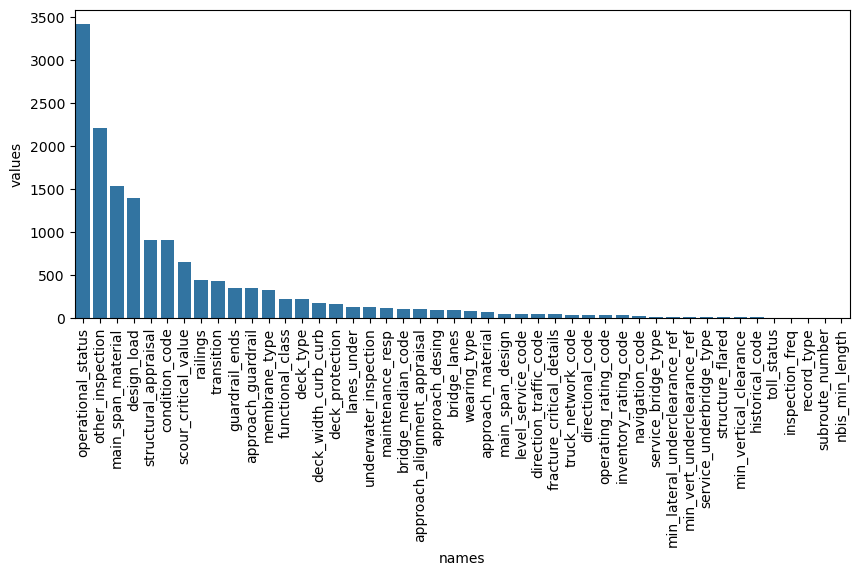

In [795]:
# plot the scores
plt.figure(figsize=(10,4))
sns.barplot(x='names', y='values', data=feature_imp)
plt.xticks(rotation = 90)
plt.show()


In [719]:
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc, 7)

In [721]:
fs.get_feature_names_out()

array(['x0', 'x18', 'x23', 'x25', 'x26', 'x27', 'x45'], dtype=object)

In [723]:
print(X_train_fs.shape)
print(X_test_fs.shape)

(9732, 7)
(4794, 7)


In [725]:
bridge_df_numeric = bridge_df.select_dtypes(include='number')

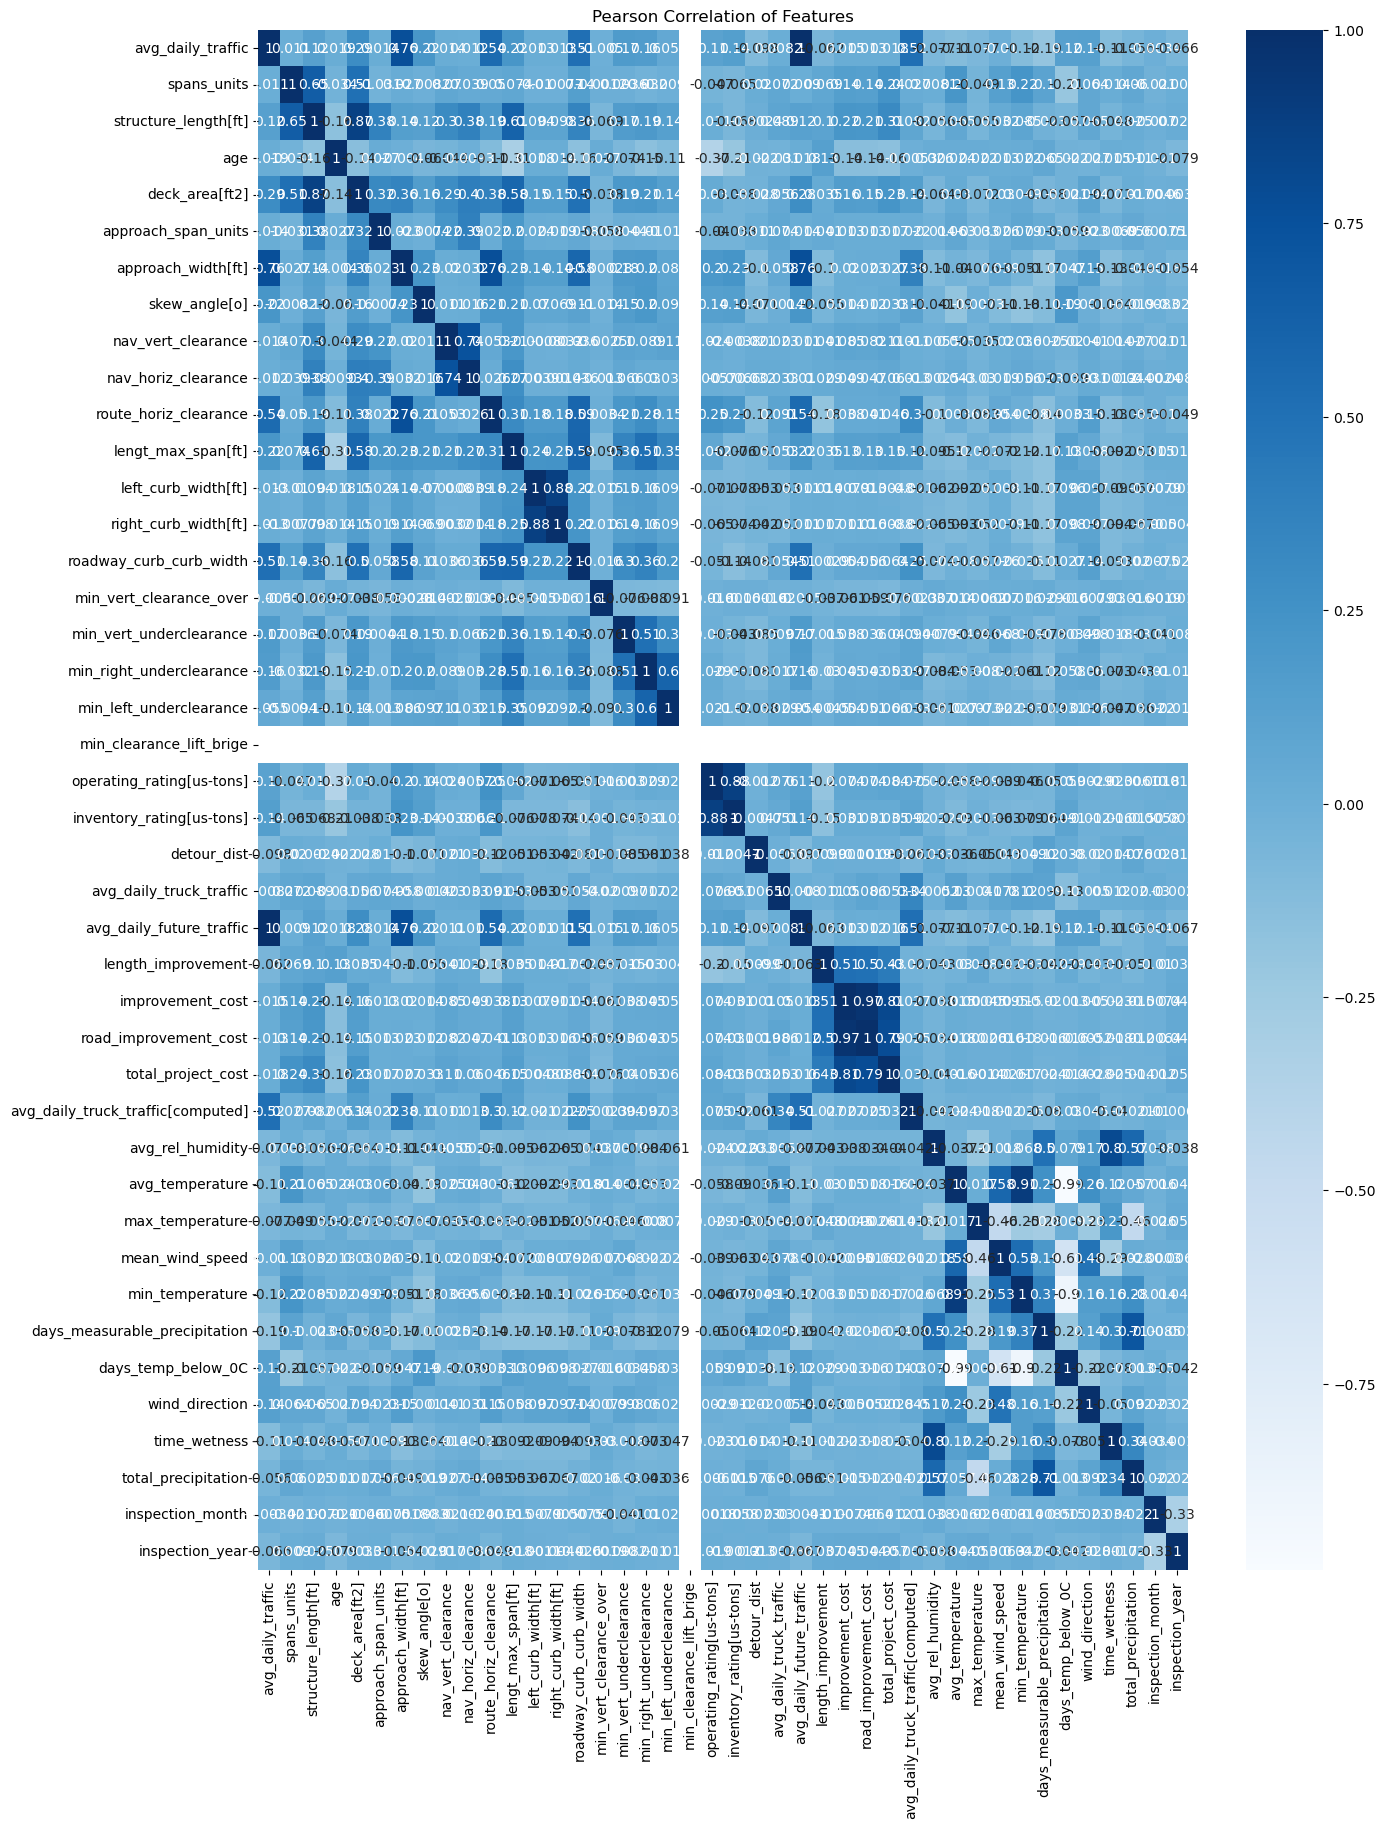

In [727]:
corr = bridge_df_numeric.corr()

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax)
plt.title('Pearson Correlation of Features')
plt.yticks(rotation=0);

### 2.2 Select best features using Pipeline and RandomForestClassifier

In [992]:
column_trans = ColumnTransformer(transformers=
        [('num', StandardScaler(), selector(dtype_include='number')),
        ('cat', OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=999), selector(dtype_exclude=['number','datetime64[ns]']))],
        remainder='drop')

In [946]:
#bridge_df.select_dtypes(exclude='datetime64[ns]').dtypes

In [767]:
# Create a random forest classifier for feature importance
clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')


In [769]:
pipeline = Pipeline([('prep',column_trans),
                     ('clf', clf)])

In [771]:
X_rf = bridge_df.drop(columns=['condition_rate'])
y_rf = bridge_df['condition_rate']

In [773]:
X_train, X_test, y_train, y_test = train_test_split(X_rf, 
                                   y_rf, test_size=0.3, random_state=0)




In [789]:
#bridge_df.dtypes

In [779]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x33060e8d0>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x33060f350>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6,
                                        random_state=42))])

In [781]:
pipeline['clf'].feature_importances_[:10]

array([1.52723246e-02, 3.34216859e-03, 6.06798199e-03, 2.44238772e-02,
       7.93272390e-03, 3.65011111e-04, 8.65409597e-03, 2.57479539e-03,
       9.82882769e-05, 1.15527943e-04])

In [783]:
feat_list = []

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(X_rf, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(X_rf, pipeline['clf'].feature_importances_):
    if feature[1] > .05:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)


 Cumulative Importance = 0.9999999999999998


In [809]:
# create DataFrame using data
pd.set_option('display.max_rows',None)
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).\
                      sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp[df_imp['IMPORTANCE']>0.01]


FEATURE  IMPORTANCE    CUMSUM
87                 time_wetness    0.404221  0.404221
65           truck_network_code    0.120266  0.524487
21              navigation_code    0.045928  0.570414
20             structure_flared    0.036094  0.606508
3                   spans_units    0.024424  0.630932
69  min_vert_underclearance_ref    0.021598  0.652530
10              approach_desing    0.021007  0.673537
25           lengt_max_span[ft]    0.017276  0.690813
0             avg_daily_traffic    0.015272  0.706085
61          service_bridge_type    0.015161  0.721247
68              subroute_number    0.013752  0.734999
42               guardrail_ends    0.013677  0.748676
63       direction_traffic_code    0.013534  0.762210
24        route_horiz_clearance    0.012755  0.774965
64      avg_daily_truck_traffic    0.010264  0.785229

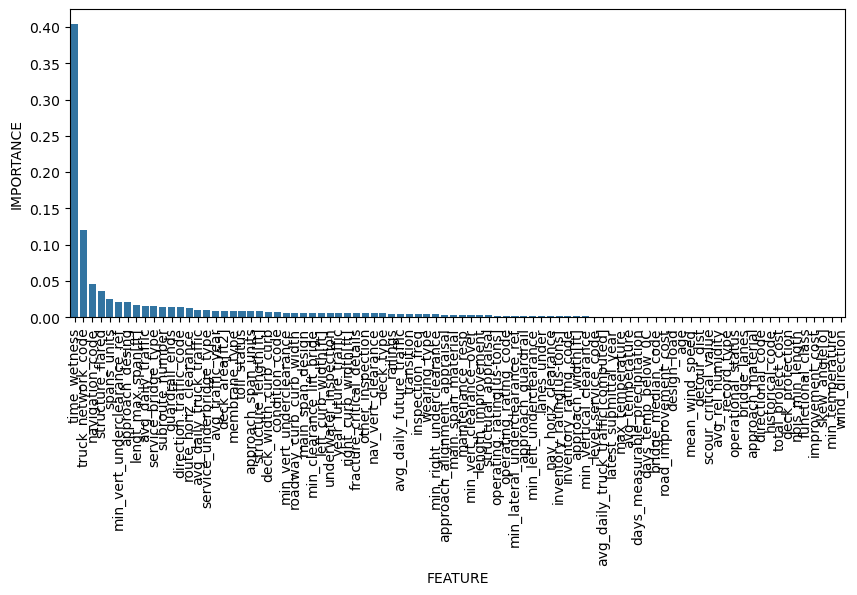

In [829]:
# plot the scores
plt.figure(figsize=(10,4))
sns.barplot(x='FEATURE', y='IMPORTANCE', data=df_imp)
plt.xticks(rotation = 90)
plt.show()


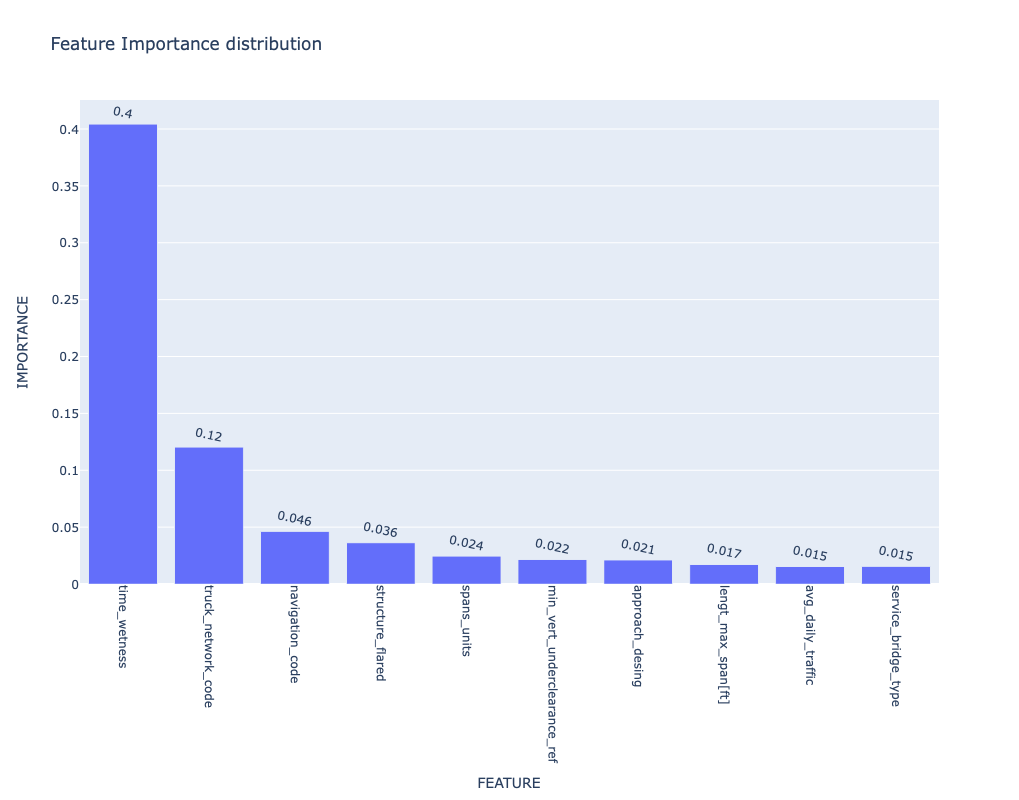

In [875]:

df_imp_10 = df_imp.head(10)

fig = px.bar(df_imp_10, x='FEATURE', y='IMPORTANCE', title= 'Feature Importance distribution', barmode='group',
             text_auto='.2',height=800)

fig.update_traces(textfont_size=12, textangle=12, textposition="outside", cliponaxis=False)
fig.update_xaxes(tickangle=90)
fig.show()

/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_82268/388438788.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_82268/388438788.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_82268/388438788.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_82268/388438788.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/t_/b22p81fn1pl5k6gntglcfzsr0000gn/T/ipykernel_82268/388438788.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number

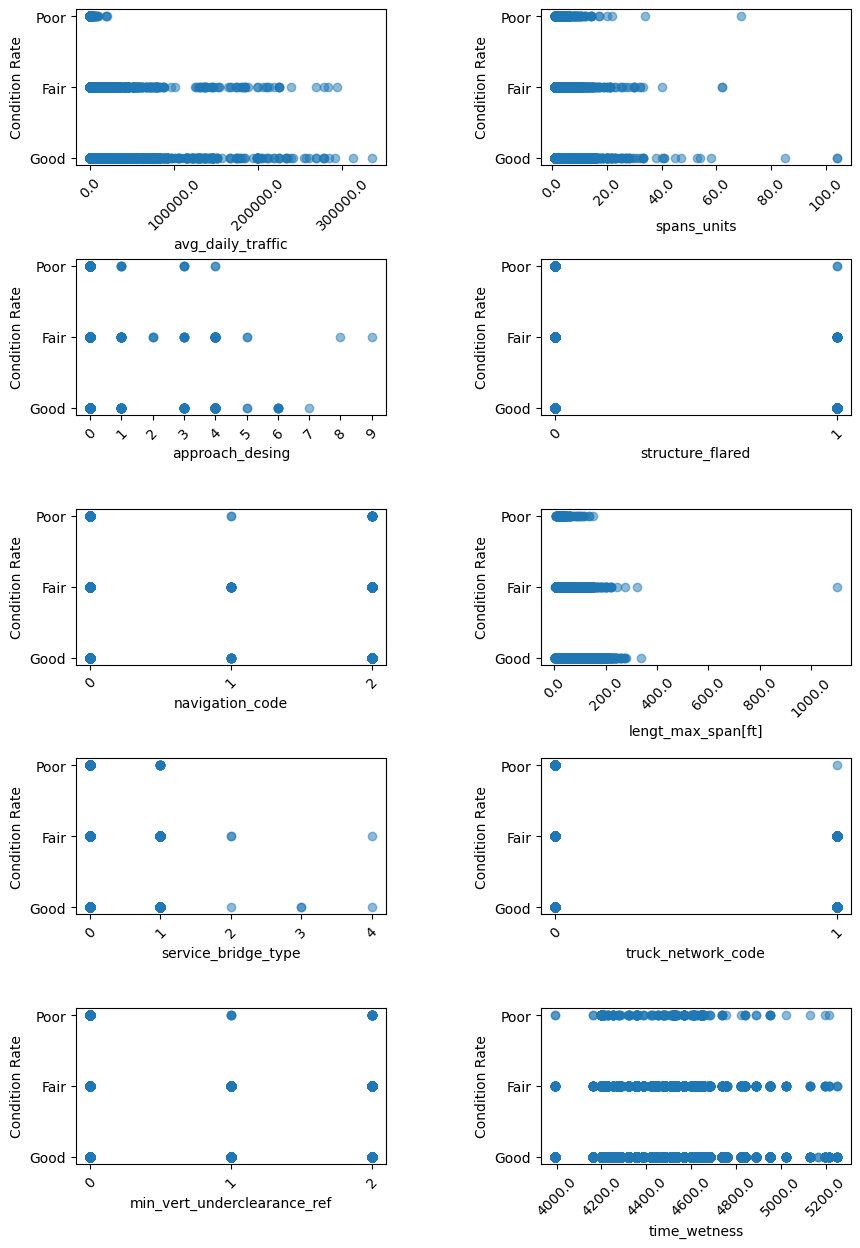

In [928]:
# define useful function to create scatterplots of condition rate against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'condition_rate', data=bridge_df, alpha=0.5, )
        ax.set(xlabel=col, ylabel='Condition Rate')
        ax.set_xticklabels(ax.get_xticks(),rotation=45)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)


selected_features= df_imp['FEATURE'].head(10).to_list()

features = [x for x in bridge_df.columns if x in selected_features]        
        

scatterplots(features, ncol=2, figsize=(10, 15))

### 2.3 Search best features using Column Transformer, Logistic Regression and PCA

In [994]:
pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=0.1)

pipeline_pca = Pipeline(steps=[('prep',column_trans),
                     ('pca', pca),('logistic', logistic)])

In [996]:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipeline_pca, param_grid, n_jobs=2)


In [998]:
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x339262e90>),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=999),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x339262790>)])),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(max_iter=10000,
                                                           tol=0.1))]),
             n_jobs=2,
             param_grid={'logistic__C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04]),
                         'pca__n_components': [5, 15, 30, 45, 60]})

In [1000]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.949):
{'logistic__C': 10000.0, 'pca__n_components': 60}


### Saving cleaned bridge dataframe to CSV

In [268]:
##Saving cleaned bridge dataframe to CSV

bridge_df.to_csv('../Data/bridge_df_cleaned.csv',index=False)

In [32]:
#pd.options.mode.copy_on_write = True 

#cat_columns = identify_columns_by_type(n_bridges,'category')

#n_bridges_cat = n_bridges[cat_columns]

#n_bridges_cat_c = n_bridges_cat.dropna(how = 'any', axis=0, inplace=False)

#identify_columns_with_na(dataset = n_bridges_cat_c)


In [30]:
#%matplotlib notebook

#dython.nominal.associations(n_bridges_cat_c, nom_nom_assoc="theil", figsize=(15, 15))



#help(dython)
